In [1]:
import logging
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import textwrap

In [2]:
# Try to install caas_jupyter_tools if available, else fallback to None

try:
    import caas_jupyter_tools
    from caas_jupyter_tools import display_dataframe_to_user
except ImportError:
    display_dataframe_to_user = None

In [3]:
RANDOM_SEED = 42
DATA_PATH = Path("../data/raw/synthetic_coffee_health_10000.csv")  # <= set to your CSV filename
OUTPUT_DIR = Path("../outputs/reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
log = logging.getLogger("data_understanding")
np.random.seed(RANDOM_SEED)

In [5]:
def safe_load_csv(path: Path) -> pd.DataFrame:
    """Load CSV safely; raise helpful message if not found."""
    log.info(f"Loading data from: {path.resolve()}")
    if not path.exists():
        raise FileNotFoundError(f"Data file not found at: {path.resolve()}")
    df = pd.read_csv(path, low_memory=False)
    log.info(f"Loaded dataframe with shape {df.shape}")
    return df

In [6]:
def show_df(df: pd.DataFrame, title: str, n: int = 8):
    """Display DataFrame nicely if environment supports it, else print head."""
    if display_dataframe_to_user:
        display_dataframe_to_user(title, df.head(n))
    else:
        print(f"\n--- {title} (first {n} rows) ---")
        print(df.head(n))

In [7]:
def save_df(df: pd.DataFrame, filename: str):
    path = OUTPUT_DIR / filename
    df.to_csv(path, index=False)
    log.info(f"Saved: {path}")
    return path

In [8]:
df = safe_load_csv(DATA_PATH)

INFO: Loading data from: /Users/yasiruvithana/coffee-minining/data/raw/synthetic_coffee_health_10000.csv
INFO: Loaded dataframe with shape (10010, 16)


In [9]:
print("\n=== BASIC OVERVIEW ===")
print("shape:", df.shape)
print("columns:", list(df.columns))
show_df(df, "Sample rows")


=== BASIC OVERVIEW ===
shape: (10010, 16)
columns: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

--- Sample rows (first 8 rows) ---
   ID   Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1  40.0    Male  Germany            3.5        328.1          7.5   
1   2  33.0    Male  Germany            1.0         94.1          6.2   
2   3  42.0    Male   Brazil            5.3        503.7          5.9   
3   4  53.0    Male  Germany            2.6        249.2          7.3   
4   5  32.0  Female    Spain            3.1        298.0          5.3   
5   6  32.0    Male   Mexico            3.4        326.4          6.4   
6   7  53.0    Male   France            2.7        252.1          7.8   
7   8  44.0  Female   Canada            4.5        423.5          5.5   

  Sleep_Quality   BMI  Hea

In [10]:
types = df.dtypes.astype(str)
non_null = df.count()
unique = df.nunique(dropna=True)
data_dict = pd.DataFrame({
    "column": df.columns,
    "dtype": [types[c] for c in df.columns],
    "non_null_count": [int(non_null[c]) for c in df.columns],
    "unique_count": [int(unique[c]) for c in df.columns]
})
print("\n=== DATA DICTIONARY (draft) ===")
if display_dataframe_to_user:
    display_dataframe_to_user("Data Dictionary (draft)", data_dict)
else:
    print(data_dict)
save_df(data_dict, "data_dictionary_draft.csv")

INFO: Saved: ../outputs/reports/data_dictionary_draft.csv



=== DATA DICTIONARY (draft) ===
                     column    dtype  non_null_count  unique_count
0                        ID    int64           10010         10008
1                       Age  float64           10009            61
2                    Gender   object           10008             3
3                   Country   object           10008            20
4             Coffee_Intake  float64           10009            80
5               Caffeine_mg  float64           10008          4279
6               Sleep_Hours  float64           10008            73
7             Sleep_Quality   object           10009             4
8                       BMI  float64           10009           222
9                Heart_Rate  float64           10009            60
10             Stress_Level   object           10008             3
11  Physical_Activity_Hours  float64           10009           152
12            Health_Issues   object            4066             3
13               Occupation  

PosixPath('../outputs/reports/data_dictionary_draft.csv')

In [11]:
print("\n=== MISSING VALUE REPORT ===")
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(3)
missing_report = pd.DataFrame({
    "column": df.columns,
    "missing_count": [int(missing_counts[c]) for c in df.columns],
    "missing_percent": [float(missing_pct[c]) for c in df.columns]
}).sort_values("missing_count", ascending=False)
if display_dataframe_to_user:
    display_dataframe_to_user("Missing Value Report", missing_report)
else:
    print(missing_report)
save_df(missing_report, "missing_report.csv")

INFO: Saved: ../outputs/reports/missing_report.csv



=== MISSING VALUE REPORT ===
                     column  missing_count  missing_percent
12            Health_Issues           5944           59.381
2                    Gender              2            0.020
3                   Country              2            0.020
5               Caffeine_mg              2            0.020
6               Sleep_Hours              2            0.020
10             Stress_Level              2            0.020
1                       Age              1            0.010
4             Coffee_Intake              1            0.010
7             Sleep_Quality              1            0.010
8                       BMI              1            0.010
9                Heart_Rate              1            0.010
11  Physical_Activity_Hours              1            0.010
13               Occupation              1            0.010
14                  Smoking              1            0.010
15      Alcohol_Consumption              1            0.010
0         

PosixPath('../outputs/reports/missing_report.csv')

In [12]:
print("\n=== DUPLICATES ===")
dup_count = int(df.duplicated().sum())
print("duplicate rows:", dup_count)
if dup_count > 0:
    dup_sample = df[df.duplicated(keep=False)].head(5)
    if display_dataframe_to_user:
        display_dataframe_to_user("Duplicate row sample", dup_sample)
    else:
        print(dup_sample)


=== DUPLICATES ===
duplicate rows: 2
          ID   Age Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
10000  10001  45.0   Male      USA            3.5        328.1          7.5   
10001  10001  45.0   Male      USA            3.5        328.1          7.5   
10007  10007  42.0   Male  Germany            3.2        300.0          7.0   
10008  10007  42.0   Male  Germany            3.2        300.0          7.0   

      Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
10000          Good  24.9        78.0          Low                     14.5   
10001          Good  24.9        78.0          Low                     14.5   
10007          Good  23.5        72.0          Low                     12.0   
10008          Good  23.5        72.0          Low                     12.0   

      Health_Issues Occupation  Smoking  Alcohol_Consumption  
10000      Moderate     Office      0.0                  0.0  
10001      Moderate     Office      0.0     

In [13]:
print("\n=== TARGET DETECTION ===")
target_candidates = [c for c in df.columns if ("health" in c.lower() or "status" in c.lower() or "issue" in c.lower() or "label" in c.lower())]
if not target_candidates:
    print("No obvious target column detected. Please set target manually.")
    target_col = None
else:
    target_col = target_candidates[0]
    print("Detected candidate target column:", target_col)
    vc = df[target_col].value_counts(dropna=False)
    vc_df = vc.rename_axis(target_col).reset_index(name="count")
    vc_df["percent"] = (vc_df["count"] / vc_df["count"].sum() * 100).round(3)
    if display_dataframe_to_user:
        display_dataframe_to_user("Target distribution", vc_df)
    else:
        print(vc_df)


=== TARGET DETECTION ===
Detected candidate target column: Health_Issues
  Health_Issues  count  percent
0           NaN   5944   59.381
1          Mild   3581   35.774
2      Moderate    467    4.665
3        Severe     18    0.180


In [14]:
print("\n=== NUMERIC SUMMARY ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_summary = df[numeric_cols].describe().T
num_summary["missing_count"] = df[numeric_cols].isnull().sum().astype(int)
if display_dataframe_to_user:
    display_dataframe_to_user("Numeric summary", num_summary.reset_index().rename(columns={"index":"feature"}))
else:
    print(num_summary)
save_df(num_summary.reset_index().rename(columns={"index":"feature"}), "numeric_summary.csv")

INFO: Saved: ../outputs/reports/numeric_summary.csv



=== NUMERIC SUMMARY ===
                           count         mean          std    min      25%  \
ID                       10010.0  5005.498901  2889.780530    1.0  2503.25   
Age                      10009.0    34.960635    11.220630    5.0    26.00   
Coffee_Intake            10009.0     2.510241     1.457076   -5.0     1.50   
Caffeine_mg              10008.0   238.535801   138.320217 -100.0   138.80   
Sleep_Hours              10008.0     6.637160     1.229863    2.0     5.80   
BMI                      10009.0    23.988380     3.919603   10.0    21.30   
Heart_Rate               10009.0    70.626536     9.888265   30.0    64.00   
Physical_Activity_Hours  10009.0     7.490848     4.319170    0.0     3.80   
Smoking                  10009.0     0.200420     0.400334    0.0     0.00   
Alcohol_Consumption      10009.0     0.300729     0.458598    0.0     0.00   

                             50%       75%      max  missing_count  
ID                       5005.50  7507.750  100

PosixPath('../outputs/reports/numeric_summary.csv')

In [15]:
print("\n=== CATEGORICAL OVERVIEW ===")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
low_card_num = [c for c in numeric_cols if df[c].nunique() <= 30]
cat_cols_extended = sorted(set(cat_cols + low_card_num))
cat_rows = []
for c in cat_cols_extended:
    sample_vals = df[c].dropna().unique().tolist()[:12]
    cat_rows.append({"column": c, "unique_count": int(df[c].nunique(dropna=True)), "sample_values": ", ".join(map(str, sample_vals))})
cat_df = pd.DataFrame(cat_rows).sort_values("unique_count", ascending=False)
if display_dataframe_to_user:
    display_dataframe_to_user("Categorical overview", cat_df)
else:
    print(cat_df)
save_df(cat_df, "categorical_overview.csv")

INFO: Saved: ../outputs/reports/categorical_overview.csv



=== CATEGORICAL OVERVIEW ===
                column  unique_count  \
1              Country            20   
4           Occupation             5   
5        Sleep_Quality             4   
2               Gender             3   
3        Health_Issues             3   
7         Stress_Level             3   
0  Alcohol_Consumption             2   
6              Smoking             2   

                                       sample_values  
1  Germany, Brazil, Spain, Mexico, France, Canada...  
4        Other, Service, Office, Student, Healthcare  
5                        Good, Fair, Excellent, Poor  
2                                Male, Female, Other  
3                             Mild, Moderate, Severe  
7                                  Low, Medium, High  
0                                           0.0, 1.0  
6                                           0.0, 1.0  


PosixPath('../outputs/reports/categorical_overview.csv')


=== CORRELATION MATRIX (numeric) ===


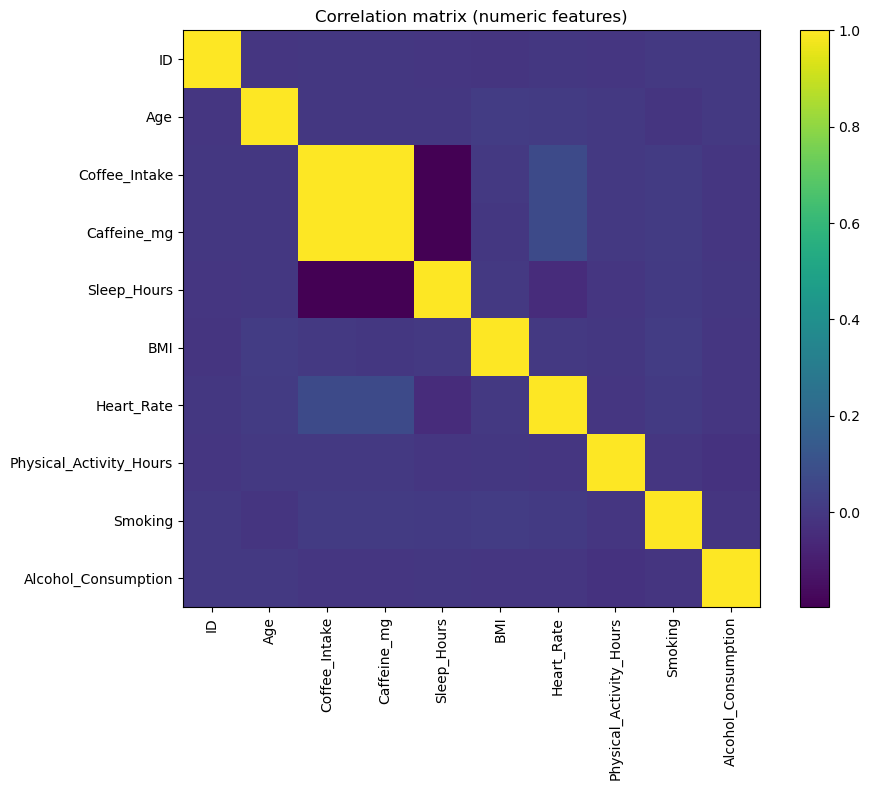

In [16]:
print("\n=== CORRELATION MATRIX (numeric) ===")
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr)  # no custom color map (best-practice for generic environments)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for correlation matrix.")


=== UNIVARIATE HISTOGRAMS (numeric; up to first 8 columns) ===


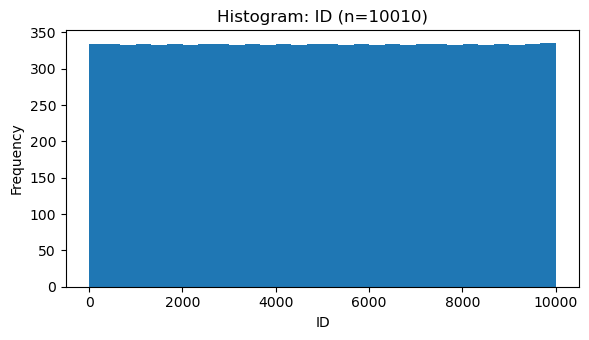

Saved plot to: ../outputs/reports/histogram_ID.png


<Figure size 640x480 with 0 Axes>

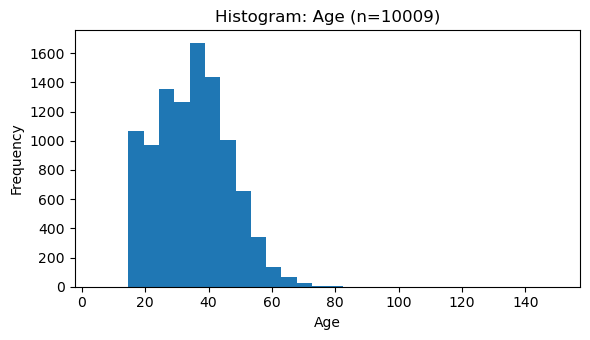

Saved plot to: ../outputs/reports/histogram_Age.png


<Figure size 640x480 with 0 Axes>

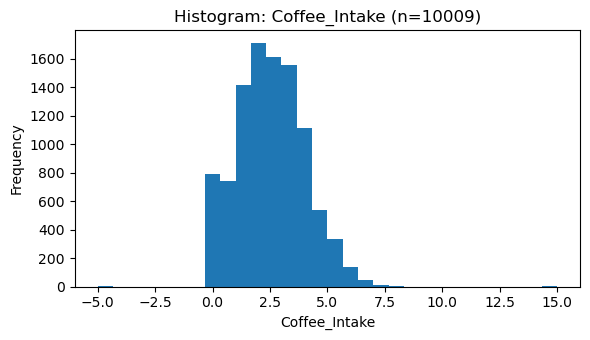

Saved plot to: ../outputs/reports/histogram_Coffee_Intake.png


<Figure size 640x480 with 0 Axes>

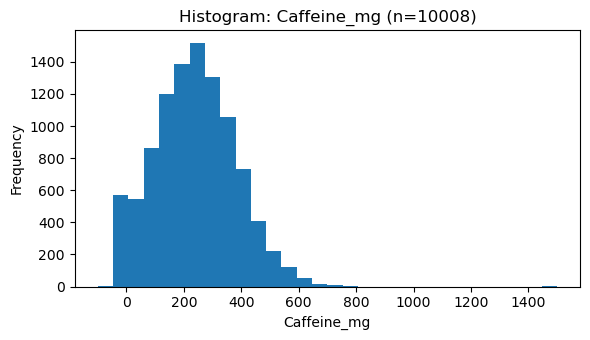

Saved plot to: ../outputs/reports/histogram_Caffeine_mg.png


<Figure size 640x480 with 0 Axes>

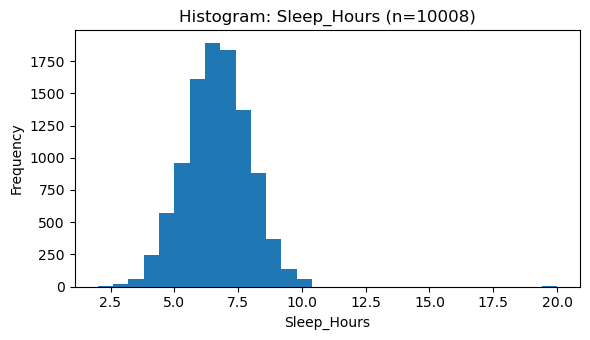

Saved plot to: ../outputs/reports/histogram_Sleep_Hours.png


<Figure size 640x480 with 0 Axes>

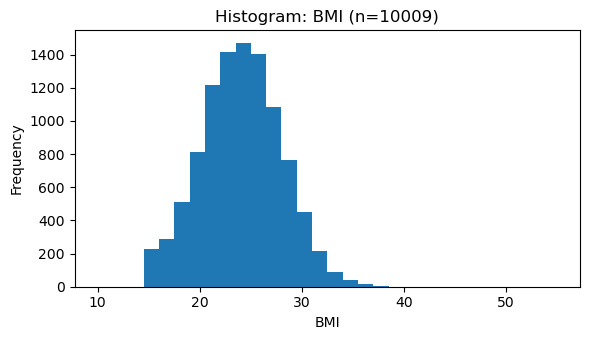

Saved plot to: ../outputs/reports/histogram_BMI.png


<Figure size 640x480 with 0 Axes>

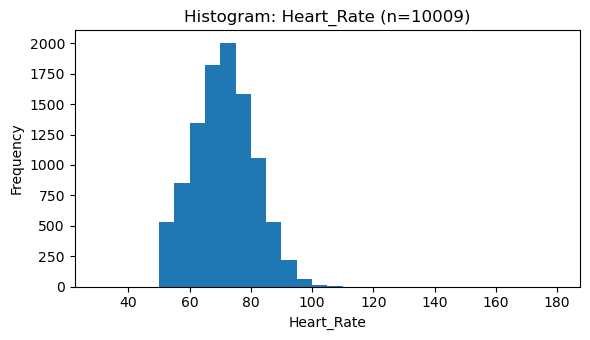

Saved plot to: ../outputs/reports/histogram_Heart_Rate.png


<Figure size 640x480 with 0 Axes>

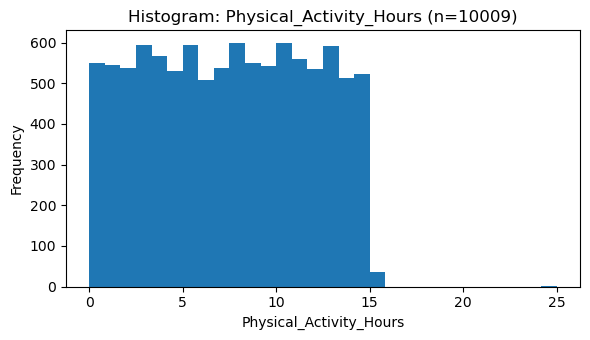

Saved plot to: ../outputs/reports/histogram_Physical_Activity_Hours.png


<Figure size 640x480 with 0 Axes>

In [17]:
print("\n=== UNIVARIATE HISTOGRAMS (numeric; up to first 8 columns) ===")
plot_cols = numeric_cols[:8]
for c in plot_cols:
    plt.figure(figsize=(6, 3.5))
    vals = df[c].dropna()
    plt.hist(vals, bins=30)
    plt.title(f"Histogram: {c} (n={len(vals)})")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    filename = f"histogram_{c}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path)
    print(f"Saved plot to: {save_path}")

In [18]:
summary = {
    "shape": df.shape,
    "num_columns": int(df.shape[1]),
    "num_rows": int(df.shape[0]),
    "numeric_columns": numeric_cols,
    "categorical_columns": cat_cols_extended,
    "detected_target": target_col,
    "duplicate_count": dup_count,
    "missing_columns": missing_report[missing_report["missing_count"]>0]["column"].tolist()
}
with open(OUTPUT_DIR / "data_understanding_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
log.info(f"Saved summary JSON to {OUTPUT_DIR/'data_understanding_summary.json'}")


INFO: Saved summary JSON to ../outputs/reports/data_understanding_summary.json


In [19]:
print("\n=== RECOMMENDED NEXT STEPS ===")
print(textwrap.dedent("""
1. Confirm the target column. If the heuristic picked the wrong column, set `target_col` explicitly.
2. Design imputation strategies per-column (mean/median for numeric, mode or 'missing' label for categorical).
3. Decide how to handle duplicates (drop vs merge after domain checks).
4. For categorical variables: choose encoding strategy (one-hot for low-cardinality, target/ordinal encoding for high-cardinality).
5. Plan scaling/normalization: StandardScaler or RobustScaler for numeric features before modeling.
6. If severe class imbalance exists, plan resampling or class-weighting strategies (SMOTE, undersampling, or class weights).
7. Start building a reproducible preprocessing Pipeline (sklearn Pipeline) so that preprocessing and modeling are deterministic.
"""))

print("\nOutputs written to folder:", OUTPUT_DIR.resolve())
print("Files created:", [p.name for p in OUTPUT_DIR.iterdir()])


=== RECOMMENDED NEXT STEPS ===

1. Confirm the target column. If the heuristic picked the wrong column, set `target_col` explicitly.
2. Design imputation strategies per-column (mean/median for numeric, mode or 'missing' label for categorical).
3. Decide how to handle duplicates (drop vs merge after domain checks).
4. For categorical variables: choose encoding strategy (one-hot for low-cardinality, target/ordinal encoding for high-cardinality).
5. Plan scaling/normalization: StandardScaler or RobustScaler for numeric features before modeling.
6. If severe class imbalance exists, plan resampling or class-weighting strategies (SMOTE, undersampling, or class weights).
7. Start building a reproducible preprocessing Pipeline (sklearn Pipeline) so that preprocessing and modeling are deterministic.


Outputs written to folder: /Users/yasiruvithana/coffee-minining/outputs/reports
Files created: ['histogram_Sleep_Hours.png', 'eda_summary.json', 'numeric_summary.csv', 'histogram_BMI.png', 'missi